### Pacotes utilizados

In [20]:
# bibliotecas
from variables import filenames
from load_dataset import load
from pre_processing import apply
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import stats_df
import pylab as pl
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
# modelos
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
# métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
import random
from sklearn.model_selection import RandomizedSearchCV
import shap

pl.rc('text', usetex=True)
pl.rc('font',**{'family':'serif','serif':['Palatino']})

%matplotlib inline

-----

### Carregamento do dataset

In [2]:
df = load(filenames=filenames)

In [3]:
stats_df(df)

Número de registros: 2830743. Número de colunas: 79;


### Análise do dataset

In [4]:
# Separando X e y.

df.columns = df.columns.str.strip() # tira o espaço que vem dos csvs.

columns_experiment = ["Destination Port", "Total Fwd Packets", "Total Backward Packets", "Total Length of Fwd Packets", "Total Length of Bwd Packets", "Flow Duration", "Flow Packets/s", "Flow Bytes/s", "Down/Up Ratio", "Label"]
target = "Label"

df = df[columns_experiment]

In [5]:
df.dtypes

Destination Port                 int64
Total Fwd Packets                int64
Total Backward Packets           int64
Total Length of Fwd Packets      int64
Total Length of Bwd Packets      int64
Flow Duration                    int64
Flow Packets/s                 float64
Flow Bytes/s                   float64
Down/Up Ratio                    int64
Label                           object
dtype: object

In [6]:
stats_df(df)

Número de registros: 2830743. Número de colunas: 10;


In [7]:
# descomentar para salvar os gráficos.
# for clm in columns_experiment[:-1]: # todas execto o label que é Object.
#     fig, ax = plt.subplots(figsize=(6, 4))
#     sns.violinplot(df[clm])
#     plt.xlabel(clm)

#     mean = df[clm].mean()
#     median = df[clm].median()
#     min = df[clm].min()
#     max = df[clm].max()

#     ax.text(
#         0.95, 0.95,  
#         f"Média: {mean:.2f}\n"
#         f"Mediana: {median:.2f}\n"
#         f"Mínimo: {min:.2f}\n"
#         f"Máximo: {max:.2f}",
#         transform=ax.transAxes, 
#         fontsize=10,
#         va="top", ha="right",
#         bbox=dict(facecolor="white", alpha=0.7, boxstyle="round,pad=0.3") 
#     )

#     plt.tight_layout()
#     filename = clm.replace('/', 'p')
#     plt.savefig(f"no_preprocessing/{filename}.png", dpi=300)
#     plt.close()

In [8]:
# remove caractere invalido dentro do target.
df[target] = df[target].str.replace('\ufffd', '', regex=False)

In [9]:
df[target].value_counts()

Label
BENIGN                       2273097
DoS Hulk                      231073
PortScan                      158930
DDoS                          128027
DoS GoldenEye                  10293
FTP-Patator                     7938
SSH-Patator                     5897
DoS slowloris                   5796
DoS Slowhttptest                5499
Bot                             1966
Web Attack  Brute Force         1507
Web Attack  XSS                  652
Infiltration                      36
Web Attack  Sql Injection         21
Heartbleed                        11
Name: count, dtype: int64

### Pré-processamento

In [10]:
apply(df)

Inicia pré-processamento.
Número de registros: 2830743. Número de colunas: 10;
1) Remove duplicatas
Número de registros: 2276769. Número de colunas: 10;
2) Substitui valores infinitos pelas medianas
Quantidade de valores alterados:  2568
3) Prenche nan


In [11]:
# diminuição de 16%
stats_df(df)

Número de registros: 2276769. Número de colunas: 10;


In [12]:
df["Class"] = (df["Label"] != "BENIGN").astype(int)
df.drop(["Label"], axis=1, inplace=True)

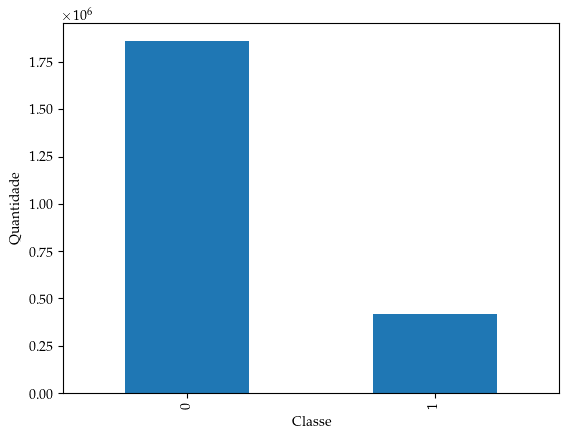

In [13]:
df["Class"].value_counts().plot(kind='bar')
plt.xlabel("Classe")
plt.ylabel("Quantidade")
plt.show()
plt.close()

In [14]:
# separando features do que irá prever.
X = df[columns_experiment[:-1]]
y = df['Class']

features = columns_experiment[:-1]
target = 'Class'

In [15]:
rus = RandomUnderSampler(random_state=42)

X,y = rus.fit_resample(X, y)

### Processamento que será utilizado no treino

In [16]:
def prepare_data(X, y, seed):
    # divide treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y, shuffle=True)
    
    # normaliza
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

In [24]:
def show_classification_metrics(y_true, y_pred):
    print("Acurácia:", accuracy_score(y_true, y_pred))
    print("Precisão:", precision_score(y_true, y_pred, average='binary'))
    print("Recall:", recall_score(y_true, y_pred, average='binary'))
    print("F1 Score:", f1_score(y_true, y_pred, average='binary'))

### Treinamento

In [21]:
X_train, X_test, y_train, y_test = prepare_data(X, y, 42)
model = LogisticRegression(n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
show_classification_metrics(y_test, y_pred)

Acurácia: 0.6729075286907409
Precisão: 0.6945554672890522
Recall: 0.6729075286907409
F1 Score: 0.6635483934511069


In [22]:
X_train, X_test, y_train, y_test = prepare_data(X, y, 42)
model = KNeighborsClassifier(n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
show_classification_metrics(y_test, y_pred)

Acurácia: 0.972541008231689
Precisão: 0.9728251647889715
Recall: 0.972541008231689
F1 Score: 0.972536882063273


In [23]:
X_train, X_test, y_train, y_test = prepare_data(X, y, 42)
model = RandomForestClassifier(n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
show_classification_metrics(y_test, y_pred)

Acurácia: 0.9941897494442108
Precisão: 0.9941897700689449
Recall: 0.9941897494442108
F1 Score: 0.9941897493835888


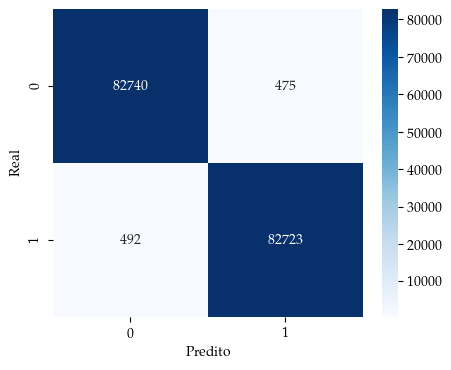

In [25]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()
plt.close()

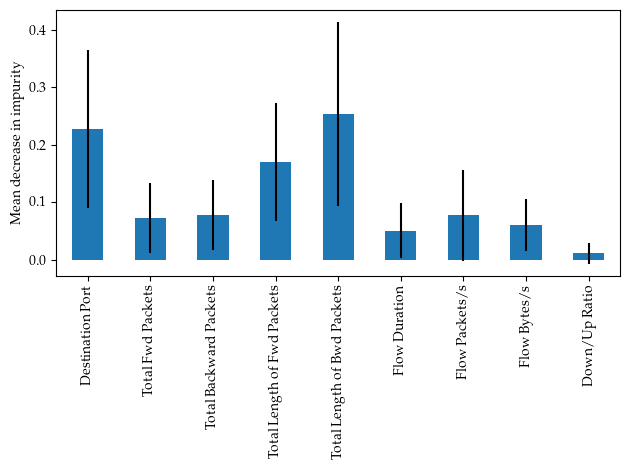

In [26]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=features)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()
plt.close()

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

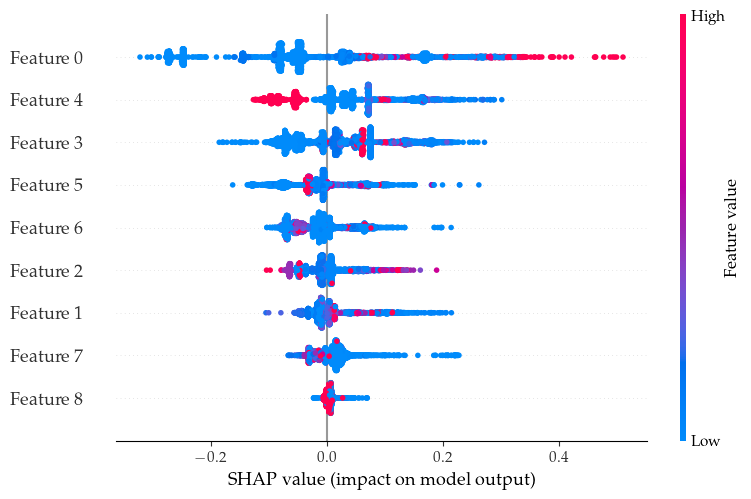

In [ ]:
shap.summary_plot(shap_values[:, :, 0], X_test, show=True, feature_names=features)

In [ ]:
from sklearn.metrics import roc_curve, auc
y_score = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ..............C=1, degree=0, gamma=0.1, kernel=poly; total time=  13.8s
[CV] END ..............C=1, degree=0, gamma=0.1, kernel=poly; total time=  14.0s
[CV] END ..............C=1, degree=0, gamma=0.1, kernel=poly; total time=  14.4s
[CV] END ..............C=1, degree=0, gamma=0.1, kernel=poly; total time=  14.3s
[CV] END ................C=1, degree=6, gamma=1, kernel=poly; total time=  17.0s
[CV] END ................C=1, degree=6, gamma=1, kernel=poly; total time=  16.8s
[CV] END ................C=1, degree=6, gamma=1, kernel=poly; total time=  16.9s
[CV] END ..............C=1, degree=0, gamma=0.1, kernel=poly; total time=  17.8s
[CV] END ............C=1, degree=0, gamma=0.1, kernel=linear; total time=  11.0s
[CV] END ............C=1, degree=0, gamma=0.1, kernel=linear; total time=  11.2s
[CV] END ................C=1, degree=6, gamma=1, kernel=poly; total time=  14.3s
[CV] END ................C=1, degree=6, gamma=1,